<a href="https://colab.research.google.com/github/WebberMark02/machine-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo le librerie necessarie e scelgo di utilizzare "tensorflow" come
backend per "Keras".

In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from matplotlib import pyplot as plt
import sklearn
from tensorflow.keras.datasets import mnist, fashion_mnist

Imposto le variabili globali.

In [2]:
seed = 42
training_set_size = 200000
testing_set_size = 5000
validation_set_size = 20000
image_shape = (32, 32, 1)
batch_size = 256
epochs = 250
learning_rate = 0.01
early_stopping_patience = 50
reduce_lr_patience = 10

Definisco il generatore di immagini sulle quali il modello
verrà addestrato e testato.  
Il generatore restituisce "batchsize" immagini; ogni immagine è
la media di due immagini scelte casualmente rispettivamente da 'x1' e 'x2'.  
Il generatore restituisce, inoltre, per ogni media di immagini, la coppia delle immagini delle quali è stata calcolata la media stessa.

In [3]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definisco una funzione per il controllo del bilanciamento delle classi.  
Mi servirà per verificare che la divisione stratificata abbia avuto successo.

In [4]:
def stampa_percentuale(y, title = ""):
  if title:
    print(title)
  # Calcolo le occorrenze di ciascuna classe nel dataset.
  unique, counts = np.unique(y, return_counts = True)
  # Calcolo la % di occorrenze per ciascuna classe.
  percentuali = (counts / len(y)) * 100
  # Stampo le occorrenze e le percentuali.
  for classe, conteggio, percentuale in zip(unique, counts, percentuali):
      print(f"Classe {classe}: Occorrenze = {conteggio}, Percentuale {percentuale} %" )
  print(f"Totale occorrenze : {sum(counts)}")
  print()

Definisco un modello banale.
Mi servirà per valutare che la rete abbia prestazioni migliori di esso.

In [5]:
def ide_model(x):
   return((x,x))

Ora ha inizio la fase di caricamento e preparazione dei dataset che verranno utilizzati
per addestrare e esaminare le prestazioni della rete.

Prima di tutto, carico i training set e i testing set di "MNIST" e "Fashion MNIST".

In [6]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

print(np.shape(mnist_x_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Ridimensiono le immagini tramite padding, portando la loro risoluzione da 28x28 a 32x32.  
Inoltre, le normalizzo nell'intervallo [0, 1].

In [7]:
#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(np.shape(mnist_x_train))

(60000, 32, 32)


Controllo il bilanciamento delle classi nei training set prima della divisione stratificata.

In [8]:
stampa_percentuale(mnist_y_train, 'MNIST training set completo')
stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set completo')

MNIST training set completo
Classe 0: Occorrenze = 5923, Percentuale 9.871666666666666 %
Classe 1: Occorrenze = 6742, Percentuale 11.236666666666666 %
Classe 2: Occorrenze = 5958, Percentuale 9.93 %
Classe 3: Occorrenze = 6131, Percentuale 10.218333333333334 %
Classe 4: Occorrenze = 5842, Percentuale 9.736666666666666 %
Classe 5: Occorrenze = 5421, Percentuale 9.035 %
Classe 6: Occorrenze = 5918, Percentuale 9.863333333333333 %
Classe 7: Occorrenze = 6265, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 5851, Percentuale 9.751666666666667 %
Classe 9: Occorrenze = 5949, Percentuale 9.915000000000001 %
Totale occorrenze : 60000

Fashion MNIST training set completo
Classe 0: Occorrenze = 6000, Percentuale 10.0 %
Classe 1: Occorrenze = 6000, Percentuale 10.0 %
Classe 2: Occorrenze = 6000, Percentuale 10.0 %
Classe 3: Occorrenze = 6000, Percentuale 10.0 %
Classe 4: Occorrenze = 6000, Percentuale 10.0 %
Classe 5: Occorrenze = 6000, Percentuale 10.0 %
Classe 6: Occorrenze = 6000, Perc

Divido ogni training set in due insiemi: il training set e il validation set.
Le immagini dei validation set verranno usate per l'ottimizzazione degli iper-parametri della rete.
Ogni validation set conterrà il 20% delle immagini del training set di partenza.
Uso la stratificazione per mantenere le classi nelle stesse proporzioni.

In [9]:
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = sklearn.model_selection.train_test_split(mnist_x_train, mnist_y_train, test_size=0.2, stratify=mnist_y_train, random_state=seed)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = sklearn.model_selection.train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.2, stratify=fashion_mnist_y_train, random_state=seed)

Controllo il bilanciamento delle classi nei training set e nei validation set ottenuti dalla divisione stratificata.

In [10]:
stampa_percentuale(mnist_y_train, 'MNIST training set risultante')
stampa_percentuale(mnist_y_val, 'MNIST validation set risultante')

stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set risultante')
stampa_percentuale(fashion_mnist_y_val, 'Fashion MNIST validation set risultante')

MNIST training set risultante
Classe 0: Occorrenze = 4738, Percentuale 9.870833333333334 %
Classe 1: Occorrenze = 5394, Percentuale 11.2375 %
Classe 2: Occorrenze = 4766, Percentuale 9.929166666666667 %
Classe 3: Occorrenze = 4905, Percentuale 10.21875 %
Classe 4: Occorrenze = 4674, Percentuale 9.7375 %
Classe 5: Occorrenze = 4337, Percentuale 9.035416666666666 %
Classe 6: Occorrenze = 4734, Percentuale 9.8625 %
Classe 7: Occorrenze = 5012, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 4681, Percentuale 9.752083333333333 %
Classe 9: Occorrenze = 4759, Percentuale 9.914583333333333 %
Totale occorrenze : 48000

MNIST validation set risultante
Classe 0: Occorrenze = 1185, Percentuale 9.875 %
Classe 1: Occorrenze = 1348, Percentuale 11.233333333333333 %
Classe 2: Occorrenze = 1192, Percentuale 9.933333333333334 %
Classe 3: Occorrenze = 1226, Percentuale 10.216666666666667 %
Classe 4: Occorrenze = 1168, Percentuale 9.733333333333333 %
Classe 5: Occorrenze = 1084, Percentuale 9.033

Creo tre istanze del generatore per generare il training set, il validation set e il testing set finali.

In [11]:
traingen = datagenerator(mnist_x_train, fashion_mnist_x_train, training_set_size)
valgen = datagenerator(mnist_x_val, fashion_mnist_x_val, validation_set_size)
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, testing_set_size)

Creo il training set e il validation set.

In [12]:
x_train, y_train = next(traingen)
x_val, y_val = next(valgen)

Verifico che le dimensioni dei due dataset siano corrette.

In [13]:
print(x_train.shape)
print(x_val.shape)

print(len(y_train))
print(len(y_val))

print(y_train[0].shape)
print(y_train[1].shape)
print(y_val[0].shape)
print(y_val[1].shape)

(250000, 32, 32)
(20000, 32, 32)
2
2
(250000, 32, 32)
(250000, 32, 32)
(20000, 32, 32)
(20000, 32, 32)


Controllo che i valori dei pixel delle immagini appartengano all'intervallo [0,1].

In [14]:
print(np.min(x_train[0]), np.max(x_train[0]))
print(np.min(x_val[0]), np.max(x_val[0]))

0.0 0.9745098039215686
0.0 0.9568627450980391


La fase di preparazione dei dataset è completa.
Ora viene definita e compilata la rete neurale.

In [15]:
def build_neural_network():
    # Input Layer
    inputs = keras.Input(shape = image_shape, name = 'InputImage')

    # Encoder 1
    enc1_conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Enc1_Conv1')(inputs)
    enc1_pool = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Enc1_Pool')(enc1_conv1)
    enc1_conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Enc1_Conv2')(enc1_pool)
    encoded1 = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Encoded1')(enc1_conv2)

    # Encoder 2
    enc2_conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Enc2_Conv1')(inputs)
    enc2_pool = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Enc2_Pool')(enc2_conv1)
    enc2_conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Enc2_Conv2')(enc2_pool)
    encoded2 = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Encoded2')(enc2_conv2)

    # Decoder 1
    dec1_conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Dec1_Conv1')(encoded1)
    dec1_upsampling1 = keras.layers.UpSampling2D((2, 2), name = 'Dec1_Upsampling1')(dec1_conv1)
    dec1_conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Dec1_Conv2')(dec1_upsampling1)
    dec1_upsampling2 = keras.layers.UpSampling2D((2, 2), name = 'Dec1_Upsampling2')(dec1_conv2)
    decoded1 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'MNIST_Image')(dec1_upsampling2)

    # Decoder 2
    dec2_conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Dec2_Conv1')(encoded2)
    dec2_upsampling1 = keras.layers.UpSampling2D((2, 2), name = 'Dec2_Upsampling1')(dec2_conv1)
    dec2_conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Dec2_Conv2')(dec2_upsampling1)
    dec2_upsampling2 = keras.layers.UpSampling2D((2, 2), name = 'Dec2_Upsampling2')(dec2_conv2)
    decoded2 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'Fashion_MNIST_Image')(dec2_upsampling2)

    model = keras.Model(inputs = inputs, outputs = [decoded1, decoded2], name = 'MNIST_Reconstruction_Model')
    return model

Istanzio la rete e mostro i suoi dettagli.

In [16]:
model = build_neural_network()
model.summary()

Model: "MNIST_Reconstruction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Conv1 (Conv2D)       │ (None, 32, 32, 32)     │            320 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Conv1 (Conv2D)       │ (None, 32, 32, 32)     │            320 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Pool (MaxPooling2D)  │ (None, 16, 16, 32)     │              0 │ Enc1_Conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Pool (MaxPooling2D)  │ (None, 16, 16, 32)     │              0 │ Enc2_Conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Conv2 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ Enc1_Pool[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Conv2 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ Enc2_Pool[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoded1 (MaxPooling2D)   │ (None, 8, 8, 64)       │              0 │ Enc1_Conv2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoded2 (MaxPooling2D)   │ (None, 8, 8, 64)       │              0 │ Enc2_Conv2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Conv1 (Conv2D)       │ (None, 8, 8, 64)       │         36,928 │ Encoded1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Conv1 (Conv2D)       │ (None, 8, 8, 64)       │         36,928 │ Encoded2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Upsampling1          │ (None, 16, 16, 64)     │              0 │ Dec1_Conv1[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Upsampling1          │ (None, 16, 16, 64)     │              0 │ Dec2_Conv1[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Conv2 (Conv2D)       │ (None, 16, 16, 32)     │         18,464 │ Dec1_Upsampling1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Conv2 (Conv2D)       │ (None, 16, 16, 32)     │         18,464 │ Dec2_Upsampling1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Upsampling2          │ (None, 32, 32, 32)     │              0 │ Dec1_Conv2[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Upsampling2          │ (None, 32, 32, 32)     │              0 │ Dec2_Conv2[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MNIST_Image (Conv2D) 

 Total params: 148,994 (582.01 KB)

 Trainable params: 148,994 (582.01 KB)

 Non-trainable params: 0 (0.00 B)

Visualizzo un plot della rete.

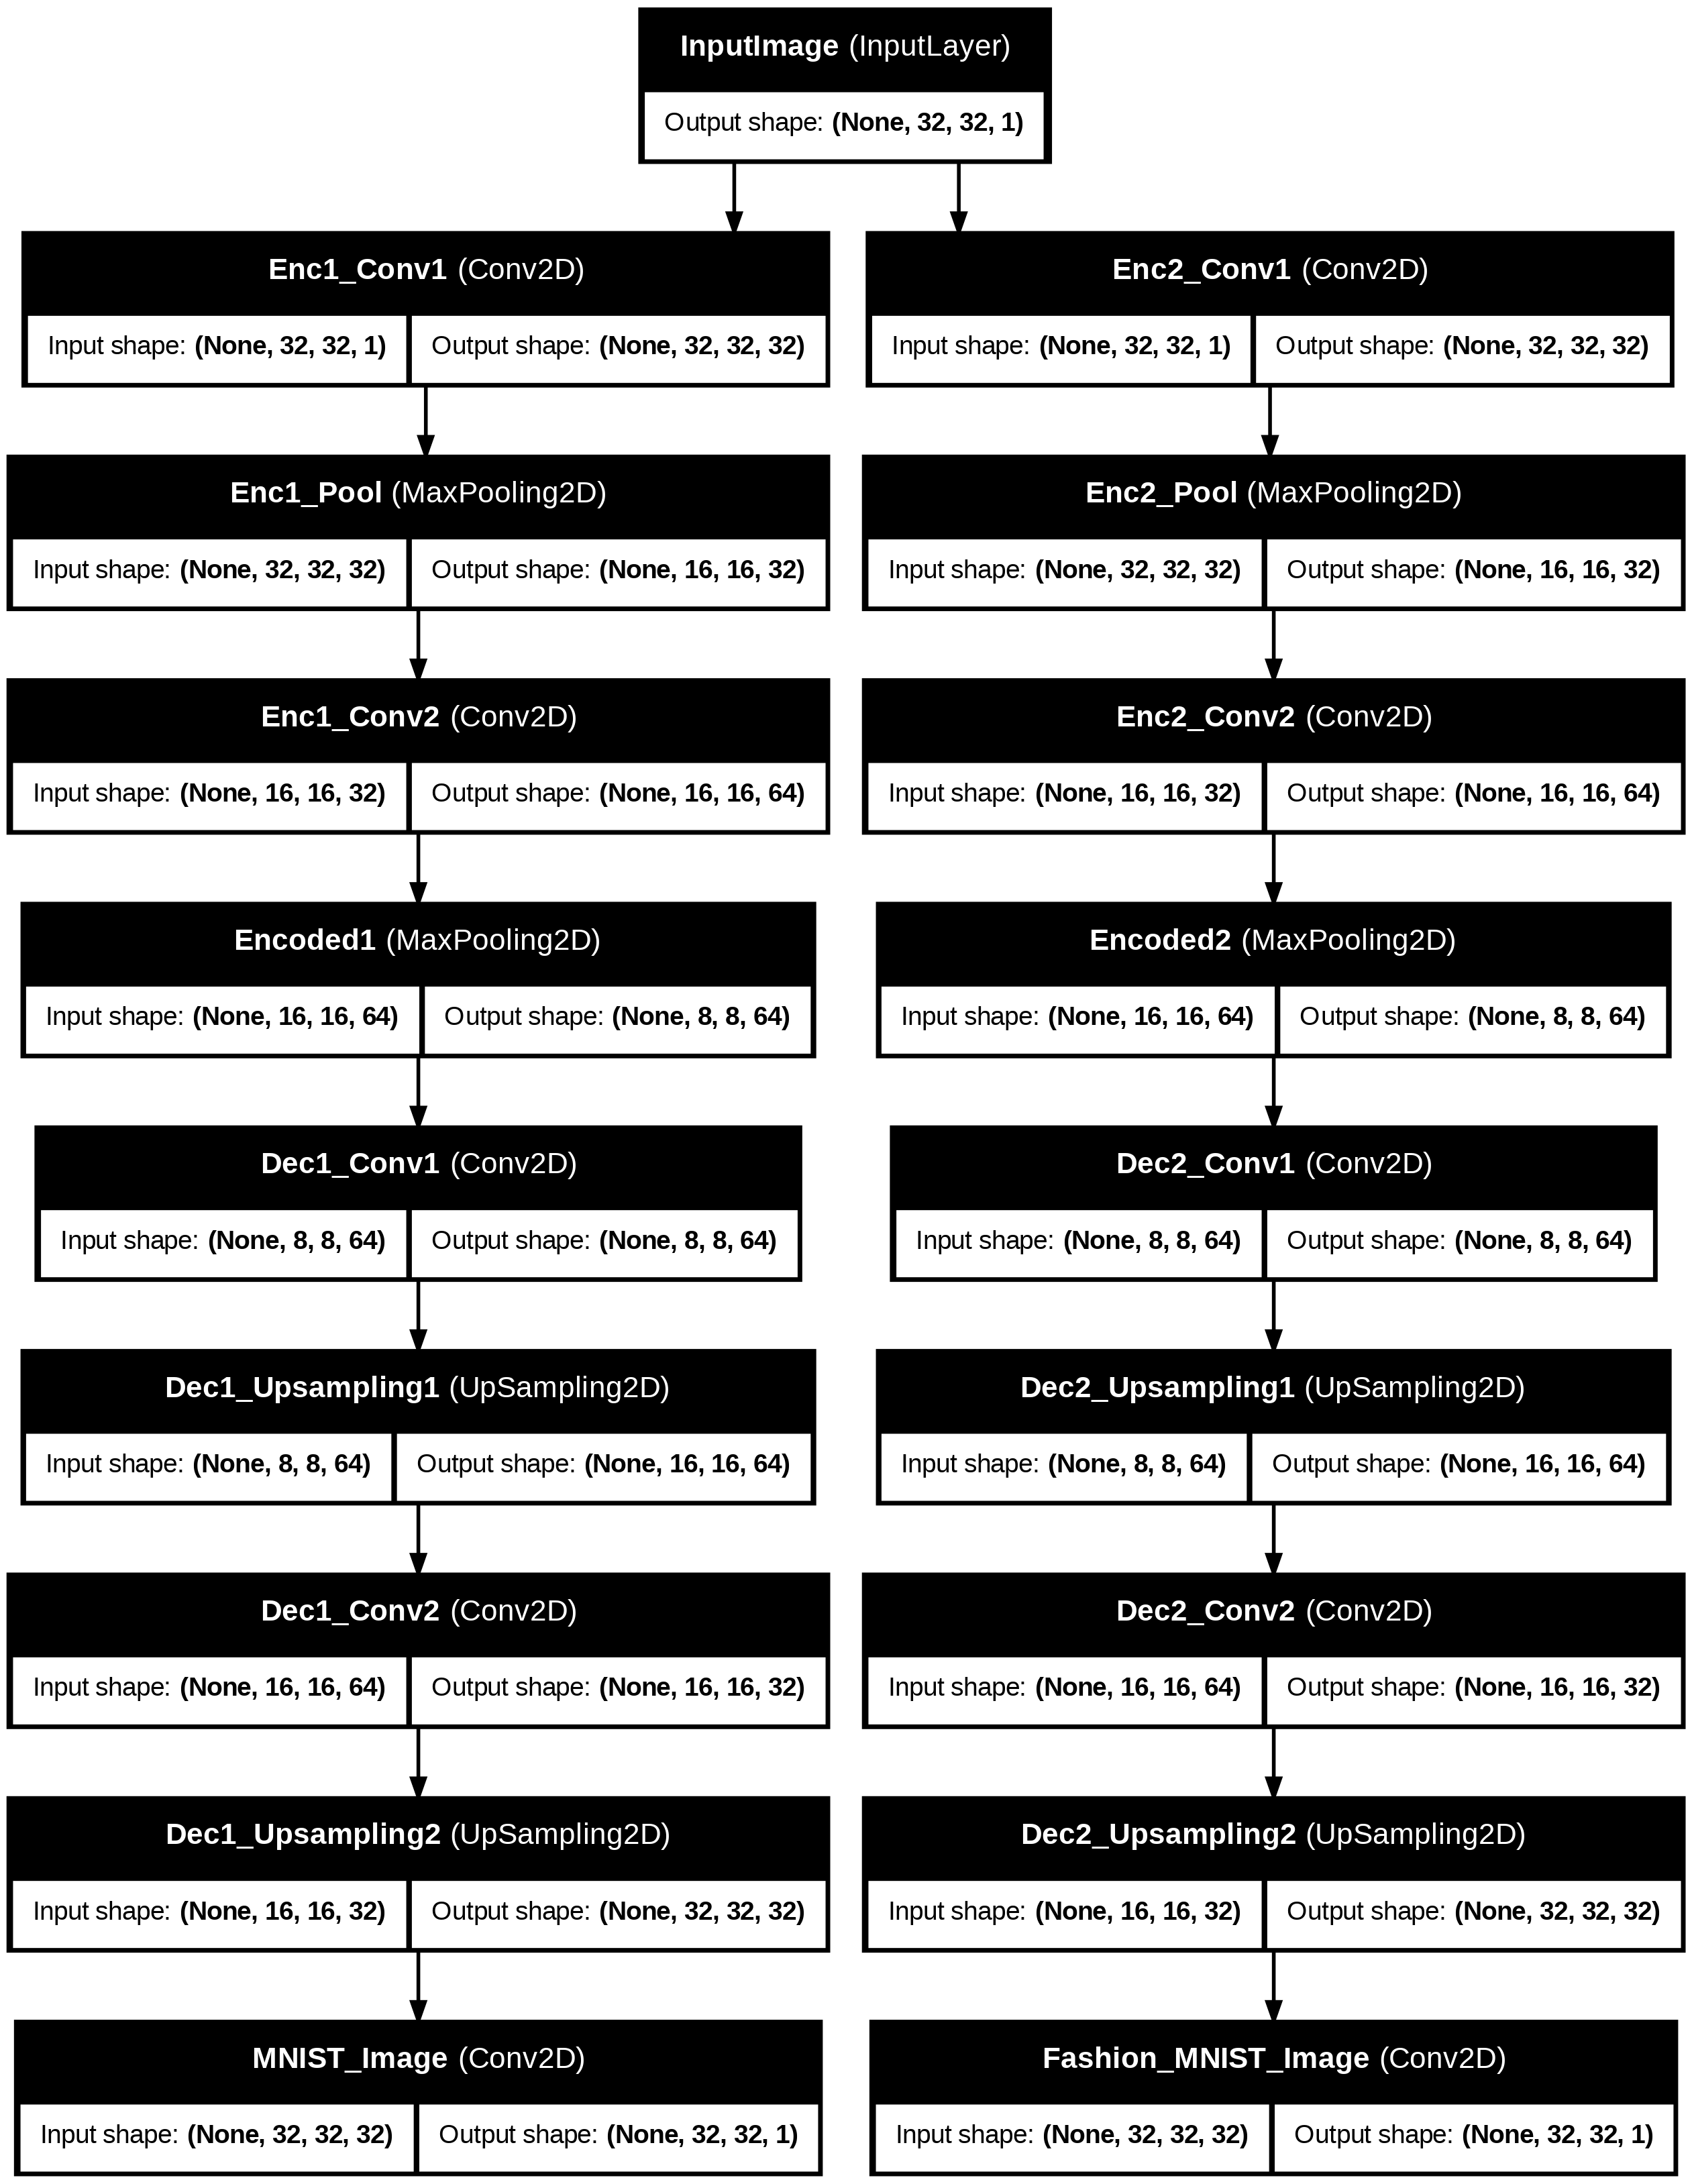

In [17]:
keras.utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True)

Definisco la funzione di costo che l'addestramento minimizzerà il più possibile.

In [18]:
mse_loss = keras.losses.MeanSquaredError(
    reduction = "sum_over_batch_size",
    name = "mean_squared_error",
    dtype=None
)

Definisco la metrica per valutare le prestazioni della rete sul validation set.

In [19]:
mse_metric = keras.metrics.MeanSquaredError(name = "mean_squared_error", dtype = None)

Compilo la rete.

In [20]:
model.compile(
    loss = [mse_loss, mse_loss],
    optimizer = keras.optimizers.AdamW(learning_rate = learning_rate),
    metrics = [mse_metric, mse_metric],
)

Definisco una callback EarlyStopping. Essa valuta alla fine di ogni epoca la loss sul validation set e decide se fermare l'addestramento oppure no. Utile per stabilire automaticamente un buon numero di epoche di addestramento della rete.

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',   # Monitora la loss sulla metrica indicata
    min_delta = 0.001,      # Variazione minima da considerare come miglioramento
    patience = early_stopping_patience,          # Numero di epoche senza miglioramenti prima di fermare l'addestramento
    mode = 'auto',          # oppure prende "min", "max", seleziona la direzione in automatico
    restore_best_weights = True,  # Ripristina i pesi migliori quando l'addestramento si ferma
    start_from_epoch = 5    # Inizia il monitoraggio dall'epoca 5
)

Definisco una callback "BackupAndRestore".  
Alla fine di ogni epoca di addestramento, essa salva la rete in un file di backup temporaneo.  
Se il notebook dovesse bloccarsi a tempo di esecuzione, sarà possibile riavviare il training ripristinando l'ultimo stato salvato nel file di backup.

In [22]:
backup_and_restore = keras.callbacks.BackupAndRestore(backup_dir = "/tmp/backup")

Definisco una callback per il controllo del learning rate.

In [23]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    min_delta = 0.001,
    factor = 0.2,
    patience = reduce_lr_patience,
    min_lr = 0.001
)

Addestro la rete.

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), callbacks = [early_stopping, backup_and_restore, reduce_lr])